In [44]:
import pandas as pd
import re

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

### Importando a base de treino

In [45]:
PATH_BASE = '../Analysis/base_total_limpa.pkl'

base = pd.read_pickle(PATH_BASE)

### Mantendo somente as features que serão utilizadas

In [46]:

base.drop(['id', 'objeto', 'origem', 'data_publicacao', 'data_inclusao', 'informacao_token'], axis = 1, inplace=True) 

In [47]:
base.head()

,informacao,interesse
0,levamos conhecimento despacho sfganeel junho p...,1
1,levamos conhecimento resolução autorizativa an...,1
2,levamos conhecimento despacho sfganeel junho p...,1
3,levamos conhecimento resolução autorizativa an...,1
4,levamos conhecimento resolução autorizativa an...,1


### Separação da base em treino e teste

In [48]:
from sklearn import model_selection

X = base['informacao'].values.reshape(-1).tolist()
Y = (base['interesse'].values.reshape(-1) == 1).tolist()

# Dividir 20% dos dados para o conjunto out-of-sample de teste
Xtrain, Xtest, Ytrain, Ytest = model_selection.train_test_split( X,
                                                                 Y,
                                                                 test_size=0.20,
                                                                 random_state=0,
                                                                 stratify=Y 
                                                                 )

### Objeto de validacao cruzada

In [49]:
from sklearn.model_selection import StratifiedKFold

cvfold = model_selection.StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True, )

### Configure Pipeline com modelos e hiper parâmetros

In [50]:
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

model_dict = {
                'AdaBoost': AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=5),
                'RandomForest': RandomForestClassifier(n_estimators=20, max_features='sqrt'),
                'NaiveBayes': MultinomialNB(),
                'LogisticRegression': LogisticRegression(),
                'DecisionTree': DecisionTreeClassifier()
             }

model_conf = {
                'RandomForest': {
                                'Model__max_depth': [4, 6],
                                'Model__n_estimators': [10, 50], 
                                },
                'LogisticRegression': {
                                      'Model__C': [0.001, 0.1, 1, 10],
                                      },
                'AdaBoost':{},
                'NaiveBayes':{},
                'DecisionTree':{}

             }

scorer = metrics.make_scorer(metrics.f1_score)   

### Adicionando stopwords específicas após análise da contagem de palavras

In [51]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk_pt_stopwords = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/marcelo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
nltk_pt_stopwords.append('nº')
nltk_pt_stopwords.append('n°')
nltk_pt_stopwords.append('n° 583')
nltk_pt_stopwords.append('ii')
nltk_pt_stopwords.append('iii')
nltk_pt_stopwords.append('ser')
nltk_pt_stopwords.append('ser')
nltk_pt_stopwords.append('§')
nltk_pt_stopwords.append('mp')
nltk_pt_stopwords.append('003 10')

### Execução do pipeline com modelos e seus hiperparâmetros utilizando grid search

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import pipeline

model_list = {}

for model_name in model_dict.keys():
    conf_train_pipe = [
        ('TfIDf', TfidfVectorizer(Xtrain,
                                  stop_words=nltk_pt_stopwords,
                                  ngram_range = (1, 2),
                                  min_df = 0.05,
                                  max_df = 0.95)),
        ('Model', model_dict[model_name])
    ]
    
    # Create Pipeline
    model_pipe = pipeline.Pipeline(conf_train_pipe)

    param_grid = model_conf[model_name].copy()
 
    model_pipe = model_selection.GridSearchCV(model_pipe, param_grid,
                                              scoring=scorer,
                                              n_jobs=-1,
                                              cv=cvfold,
                                              return_train_score = True,)
    
    

    model_pipe.fit(Xtrain, Ytrain)
    model_list[model_name] = model_pipe

### Melhor estimado

In [54]:
model_pipe.best_estimator_

Pipeline(steps=[('TfIDf',
                 TfidfVectorizer(input=['portaria agosto reitor instituto '
                                        'federal educação ciência tecnologia '
                                        'norte minas gerais uso atribuições '
                                        'conferidas decreto presidencial '
                                        'outubro publicado diário oficial '
                                        'união outubro tendo vista disposto '
                                        'artigo lei complementar publicada dou '
                                        'consta processo resolveart suspender '
                                        'prazo validade concursos públicos '
                                        'abaixo di...
                                        'horário brasíliadf via sistema '
                                        'comprasnetcomprasgovernamentaisnatalrn '
                                        'agosto tarcísio oliveir

### Curva ROC

Text(0, 0.5, 'Taxa de Detecção')

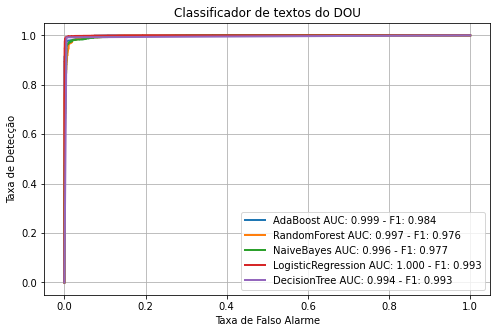

In [55]:
plt.figure(figsize=(8,5))

for model_name in model_dict.keys():
    model = model_list[model_name]
    
    # estimate Y
    if model_name in ['RandomForest', 'SVM']:
        final_model = LogisticRegression()
        if model_name == 'SVM':
            Yhat_train = model.decision_function(Xtrain)
            Yhat = model.decision_function(Xtest)
        else:
            Yhat_train = model.predict_proba(Xtrain)[:,1]
            Yhat = model.predict_proba(Xtest)[:,1]
            
        final_model.fit(Yhat_train.reshape(-1, 1), Ytrain)
        Yhat  = final_model.predict_proba(Yhat.reshape(-1,1))[:,1]
        Ypred = final_model.predict(Yhat.reshape(-1,1))
    else:
        Yhat = model.predict_proba(Xtest)[:,1]
        Ypred = model.predict(Xtest)
    
    
    fpr, tpr, thr = metrics.roc_curve(Ytest, Yhat)
    auc = metrics.roc_auc_score(Ytest, Yhat)
    f1 = metrics.f1_score(Ytest, Ypred)
    label = model_name + " AUC: %.3f - F1: %.3f"%(auc, f1)
    plt.plot(fpr, tpr, '-', lw=2, label=label)

    
plt.legend()
plt.title('Classificador de textos do DOU')
plt.grid()
plt.xlabel('Taxa de Falso Alarme')
plt.ylabel('Taxa de Detecção')

## Matriz de confusão

#### A matriz de confusão é geralmente utilizada para decrever a preformance da classificação do modelo num certo conjunto de dados em que os valores alvo #são conhecidos. Dela são retiradas algumas métricas como: Acurácia, Precisão, Sensibilidade e f1 score

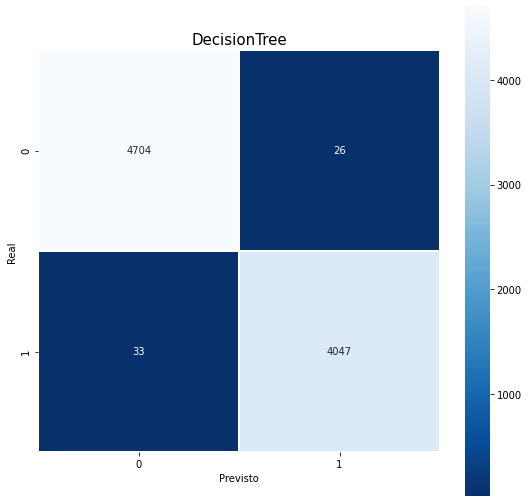

In [56]:
from sklearn import metrics

model_name = 'DecisionTree'

model = model_list[model_name]

CM = metrics.confusion_matrix(Ytest,model.predict(Xtest))
plt.figure(figsize=(9,9))
sns.heatmap(CM, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Real');
plt.xlabel('Previsto');
plt.title(model_name, size = 15);

### Da matrix de confusão podemos chegar a seguinte conclusão

* O modelo previu com sucesso 4047 de interesse
* O modelo previu com sucesso 4704 sem interesse
* O modelo previu 33 falsos positivos
* O modelo previu 26 falsos negativos

### Scores do modelo escolhido

In [58]:
print(metrics.classification_report(Ytest, Ypred))

precision    recall  f1-score   support

       False       0.99      0.99      0.99      4730
        True       0.99      0.99      0.99      4080

    accuracy                           0.99      8810
   macro avg       0.99      0.99      0.99      8810
weighted avg       0.99      0.99      0.99      8810



### Função da Distribuição de Probabilidade do modelo escolhido (KDE)

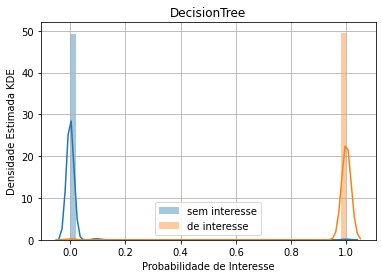

In [59]:
import numpy as np

model_name = 'DecisionTree'
model = model_list[model_name]

Yhat = model.predict_proba(Xtest)[:,1]

for i in [False, True]:
    # 2 Classes case
    sns.distplot(Yhat[np.array(Ytest) == i], label=['sem interesse','de interesse'][i])

plt.title(model_name)
plt.ylabel('Densidade Estimada KDE')
plt.xlabel('Probabilidade de Interesse')
plt.grid()
plt.legend()

In [60]:
import pickle
PATH_MODELO_TREINADO = '../../Data/Modeling/modelo_treinado_dou.jbl'

with open(PATH_MODELO_TREINADO, 'wb') as fid:
    pickle.dump(model_list, fid)